In [4]:
import pandas as pd

# Load CSV
df = pd.read_csv("retail_store_inventory.csv")

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Group by date to get daily total sales
df_grouped = df.groupby("Date")["Units Sold"].sum().reset_index()

df_grouped.head()

,Date,Units Sold
0,2022-01-01,14484
1,2022-01-02,13415
2,2022-01-03,13681
3,2022-01-04,14084
4,2022-01-05,12572


In [5]:
!pip install flask flask-cors pandas numpy plotly prophet gunicorn openpyxl
!pip install statsmodels scikit-learn
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.7 MB/s eta 0:00:00


# **Train Prophet Forecasting Model**

In [6]:
from prophet import Prophet

# Prepare data for Prophet
df_prophet = df_grouped.rename(columns={"Date": "ds", "Units Sold": "y"})

# Train model
model = Prophet()
model.fit(df_prophet)

# Make future dataframe for next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz1oiq7ca/kyrs9pwd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz1oiq7ca/ovshlilz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43797', 'data', 'file=/tmp/tmpz1oiq7ca/kyrs9pwd.json', 'init=/tmp/tmpz1oiq7ca/ovshlilz.json', 'output', 'file=/tmp/tmpz1oiq7ca/prophet_model_2qrugjd/prophet_model-20250809105950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:59:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:59:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
756,2024-01-27,13409.819947,12184.135291,14717.042056
757,2024-01-28,13564.522759,12275.898271,14835.169294
758,2024-01-29,13399.831664,12093.738894,14690.895171
759,2024-01-30,13627.740184,12290.015095,14957.909490
760,2024-01-31,13568.888177,12316.967071,14969.437869


In [7]:
from flask import Flask, request, jsonify
from flask_cors import CORS

app = Flask(__name__)
CORS(app)

@app.route('/predict', methods=['GET'])
def predict_sales():
    forecast_data = forecast.tail(30)[["ds", "yhat", "yhat_lower", "yhat_upper"]]
    return jsonify(forecast_data.to_dict(orient="records"))

if __name__ == '__main__':
    app.run(port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


## Plot Interactive Dashboard

In [8]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_grouped["Date"], y=df_grouped["Units Sold"],
                         name="Actual Sales"))
fig.add_trace(go.Scatter(x=forecast["ds"], y=forecast["yhat"],
                         name="Predicted Sales"))
fig.update_layout(title="Sales Forecast", xaxis_title="Date", yaxis_title="Units Sold")
fig.show()


# **Add Region & Category Filters**

In [9]:
def forecast_with_filter(region=None, category=None):
    df_filtered = df.copy()
    if region:
        df_filtered = df_filtered[df_filtered['Region'] == region]
    if category:
        df_filtered = df_filtered[df_filtered['Category'] == category]

    # Aggregate
    df_grouped = df_filtered.groupby("Date")["Units Sold"].sum().reset_index()
    df_prophet = df_grouped.rename(columns={"Date": "ds", "Units Sold": "y"})

    # Train Prophet
    model = Prophet()
    model.fit(df_prophet)
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)
    return forecast

# Example usage
forecast_with_filter(region="North", category="Electronics").tail()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz1oiq7ca/l7deg57l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz1oiq7ca/ahgdt44y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89317', 'data', 'file=/tmp/tmpz1oiq7ca/l7deg57l.json', 'init=/tmp/tmpz1oiq7ca/ahgdt44y.json', 'output', 'file=/tmp/tmpz1oiq7ca/prophet_modeljktw5gd1/prophet_model-20250809110133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:01:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:01:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
751,2024-01-27,707.440477,293.384325,1215.508490,707.403350,707.476848,46.005973,46.005973,46.005973,29.589924,29.589924,29.589924,16.416049,16.416049,16.416049,0.0,0.0,0.0,753.446450
752,2024-01-28,707.510938,187.616608,1221.419355,707.470927,707.550541,-4.409316,-4.409316,-4.409316,-11.127178,-11.127178,-11.127178,6.717863,6.717863,6.717863,0.0,0.0,0.0,703.101623
753,2024-01-29,707.581400,151.582448,1114.529350,707.538340,707.624144,-54.578105,-54.578105,-54.578105,-51.862962,-51.862962,-51.862962,-2.715143,-2.715143,-2.715143,0.0,0.0,0.0,653.003295
754,2024-01-30,707.651861,205.157819,1206.200007,707.605797,707.697431,8.091511,8.091511,8.091511,19.831566,19.831566,19.831566,-11.740055,-11.740055,-11.740055,0.0,0.0,0.0,715.743372
755,2024-01-31,707.722323,213.289885,1185.563676,707.673118,707.770004,-7.936581,-7.936581,-7.936581,12.294844,12.294844,12.294844,-20.231426,-20.231426,-20.231426,0.0,0.0,0.0,699.785741


In [22]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv("retail_store_inventory.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Aggregate sales per day
df_grouped = df.groupby("Date")["Units Sold"].sum().reset_index()
df_prophet = df_grouped.rename(columns={"Date": "ds", "Units Sold": "y"})

# Train-test split (last 30 days as test)
train = df_prophet.iloc[:-30]
test = df_prophet.iloc[-30:]


In [23]:
model = Prophet()
model.fit(train)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Extract predictions for test period
forecast_test = forecast[['ds', 'yhat']].tail(30)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz1oiq7ca/tuthgmcq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz1oiq7ca/udtp1gv5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94948', 'data', 'file=/tmp/tmpz1oiq7ca/tuthgmcq.json', 'init=/tmp/tmpz1oiq7ca/udtp1gv5.json', 'output', 'file=/tmp/tmpz1oiq7ca/prophet_modellqrab5fs/prophet_model-20250809112014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:20:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [24]:
mae = mean_absolute_error(test['y'], forecast_test['yhat'])
rmse = np.sqrt(mean_squared_error(test['y'], forecast_test['yhat']))
mape = np.mean(np.abs((test['y'] - forecast_test['yhat']) / test['y'])) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 985.37
RMSE: 1231.66
MAPE: 7.38%


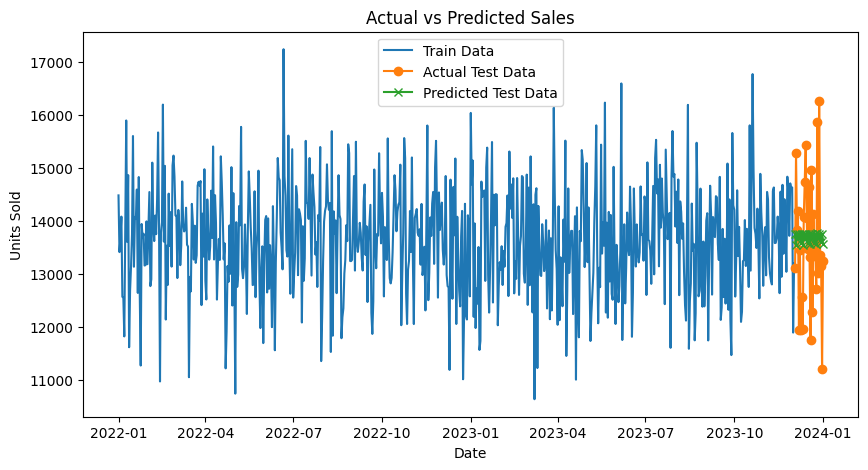

In [25]:
plt.figure(figsize=(10,5))
plt.plot(train['ds'], train['y'], label="Train Data")
plt.plot(test['ds'], test['y'], label="Actual Test Data", marker='o')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label="Predicted Test Data", marker='x')
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.title("Actual vs Predicted Sales")
plt.legend()
plt.show()


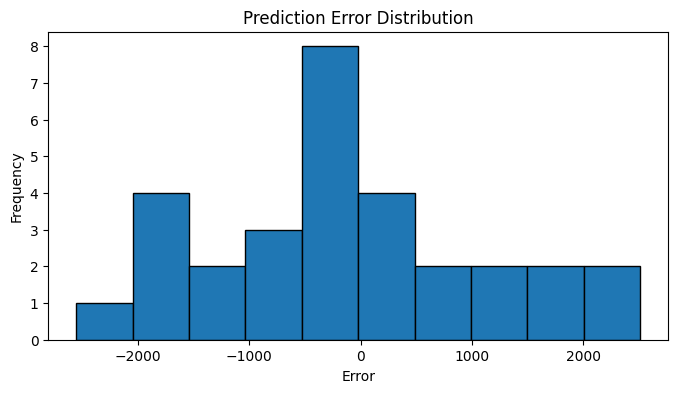

In [26]:
errors = test['y'] - forecast_test['yhat']
plt.figure(figsize=(8,4))
plt.hist(errors, bins=10, edgecolor='black')
plt.title("Prediction Error Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()


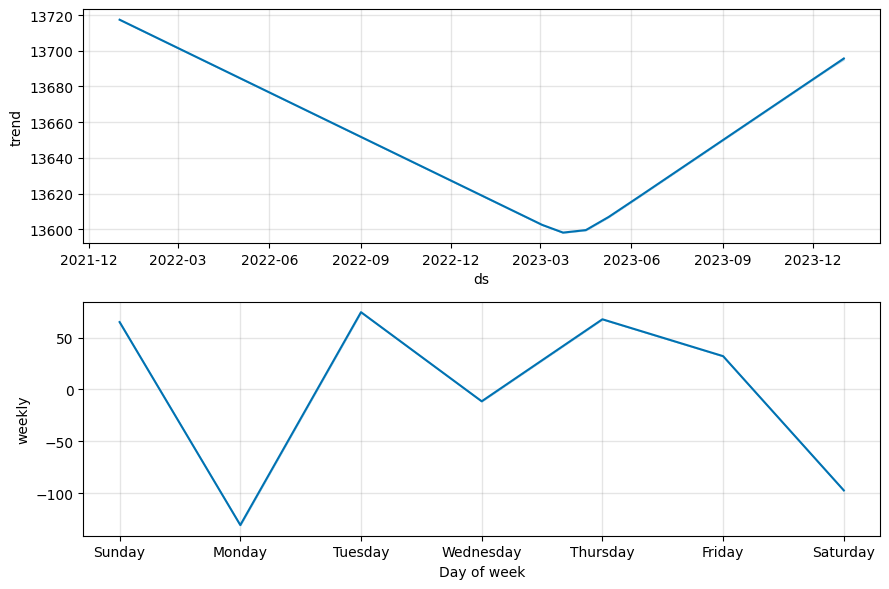

In [27]:
model.plot_components(forecast)
plt.show()
